# Link prediction project for paper citations
## Preprocessing


In [4]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss 
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import random as rand
import csv
from sklearn.utils import shuffle
import gensim
from gensim.models import Word2Vec
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from numpy import savetxt
from sklearn.ensemble import HistGradientBoostingClassifier
from gensim.models.doc2vec import Doc2Vec,TaggedDocument
from gensim.test.utils import get_tmpfile
from scipy import spatial

In [5]:
# Data preparation

dataset = pd.read_csv('datasets/edgelist.txt', sep = ',' ,header = None)


# add names to columns for easier manipulation of data
dataset.columns = ['nodes','edges']

print(dataset.head())

# check for nan values
dataset.isnull().values.any()

   nodes  edges
0      0      1
1      0      2
2      1      3
3      1      5
4      1      6


False

### Graph creation and plot

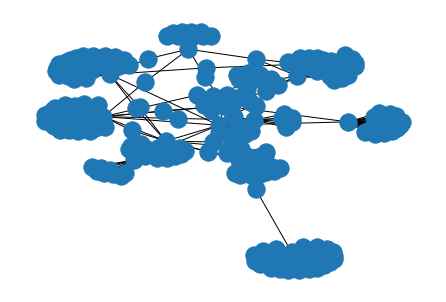

In [6]:
Graph = nx.Graph()

# add nodes

for x in dataset['nodes']:
    Graph.add_node(x)

# add edges

for x,y in dataset.itertuples(index = False):
    Graph.add_edge(x,y)
    
    

# creation of sub graph for plotting 

subset_data = pd.DataFrame(columns = ['nodes','edges'])

subset_data = dataset.head(300)

subG = nx.Graph()

for x in subset_data['nodes']:
    subG.add_node(x)
    
for x,y in subset_data.itertuples(index = False):
    subG.add_edge(x,y)
    
# plot graph

nx.draw(subG)

plt.show()

## Feature Extraction

In [7]:
m = Graph.number_of_edges()
nodeCount = Graph.number_of_nodes()
n = 18 # number of features

X_train = np.zeros((2*m,n))
y_train = np.zeros(2*m)



"""
for i in range(0,m):
    X_train[i,0] = Graph.degree[dataset['nodes'][i]] # degree of first node
    X_train[i,1] = Graph.degree[dataset['edges'][i]] # degree of second node
    X_train[i,2] = X[i,0] + X[i,1] # sum of these degrees


for i in range(m,2*m): # we take all unconnected pairs for negative sample 
    X_train[i,0] = 138499 - X[i-m,0] # Graph.degree[dataset['nodes'][rand.randint(0,m-1)]]
    X_train[i,1] = 138499 - X[i-m,1] # Graph.degree[dataset['edges'][rand.randint(0,m-1)]]
    X_train[i,2] = X[i,0] + X[i,1]

"""

# Read the abstract of each paper

abstracts = dict()
with open('datasets/abstracts.txt', 'r', encoding = 'utf8') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts[int(node)] = abstract
        
for node in abstracts:
    abstracts[node] = set(abstracts[node].split())

# Read the authors of each paper

authors = dict()
with open('datasets/authors.txt', 'r', encoding = 'utf8') as f:
    for line in f:
        node, author = line.split('|--|')
        authors[int(node)] = author        
        
for node in authors:
    authors[node] = authors[node].strip("\n")
    #authors[node] = authors[node].replace(',',' ')
    authors[node] = set(authors[node].split(","))
    
print("Arrays created successfully.")

# Author graph creation

authorGraph = nx.Graph()



for i,edge in enumerate(Graph.edges()):
    result = authors[edge[0]].intersection(authors[edge[1]])
    
    # for word in result: just in case
    for word3 in authors[edge[1]]:
        authorGraph.add_node(word3)
    
    for word in authors[edge[0]]:
        authorGraph.add_node(word)
        if result:
            for word2 in authors[edge[1]]:
                if word == word2:
                    continue
                else:
                    authorGraph.add_edge(word,word2)
                   

    
        
print(authorGraph.degree['Jian-Xun Peng'])

print("Author graph created successfully.")


authorDeg = np.zeros((m,2))
deg0 = 0
deg1 = 0

for i,edge in enumerate(Graph.edges()):
    for word in authors[edge[0]]:
        deg0 = authorGraph.degree[word]
        authorDeg[i,0] = deg0
    for word2 in authors[edge[1]]:
        deg1 = authorGraph.degree[word2]
        authorDeg[i,1] = deg1
    deg0 = 0
    deg1 = 0

"""
g_emb = n2v(
  Graph,
  dimensions=16
)
    
mdl = g_emb.fit(
    vector_size = 16,
    window = 1,
    min_count = 1,
    batch_words = 4
)

input_node = '1'
sim = mdl.wv.most_similar(input_node, topn = 10)
print(sim)
"""    
    
#for i,edge in enumerate(authorGraph.edges()):
    #authorDeg.append(authorGraph.degree[i])
    
# node2vec testing



Arrays created successfully.
12
Author graph created successfully.


"\ng_emb = n2v(\n  Graph,\n  dimensions=16\n)\n    \nmdl = g_emb.fit(\n    vector_size = 16,\n    window = 1,\n    min_count = 1,\n    batch_words = 4\n)\n\ninput_node = '1'\nsim = mdl.wv.most_similar(input_node, topn = 10)\nprint(sim)\n"

## Helpful functions for creating features

In [8]:
# Initialize x_train

def initialize_x_train(number_of_edges,list_of_features,mypath):
    mypath=mypath
    number_of_features=len(list_of_features)
    print("number_of_edges:",number_of_edges)
    #mul by 2 for the training matrix
    x=np.zeros((2*number_of_edges,number_of_features))
    for idx,feature in enumerate(list_of_features):
        print("loading column {} with feature {}".format(idx,feature))
        x[:,idx]=np.genfromtxt(mypath+feature,delimiter=',')
    return x

# Initialize x_test

def initialize_x_test(number_of_edges,list_of_features,mypath):
    mypath=mypath
    number_of_features=len(list_of_features)
    print("number_of_edges:",number_of_edges)
    #mul by 1 for the training matrix
    x=np.zeros((number_of_edges,number_of_features))
    for idx,feature in enumerate(list_of_features):
        print("loading column {} with feature {}".format(idx,feature))
        x[:,idx]=np.genfromtxt(mypath+feature,delimiter=',')
    return x

# get feature files for debugging purposes

from os import listdir
from os.path import isfile,join
def get_feature_files(mypath):
    mypath=mypath
    features_to_include=[feature for feature in listdir(mypath)]
    print("included features are: ",features_to_include)
    return features_to_include

print("Functions ready.")

Functions ready.


## Doc2vec testing

In [10]:
# Doc2Vec testing

documents = [TaggedDocument(abstracts[node], [node]) for node in abstracts]
model2 = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
print("Doc2vec done.")

Doc2vec done.


In [31]:
# doc2vec save
fname = get_tmpfile("doc2vec_model")

model2.save(fname)
print("Save done.")

Save done.


In [9]:
# doc2vec load

docmodel = Doc2Vec.load(fname)
print("Load successful.")

NameError: name 'fname' is not defined

In [43]:
docArray = np.zeros(2*m)

for i,edge in enumerate(Graph.edges()):
    docArray[i] = spatial.distance.cosine(docmodel.dv[edge[0]], docmodel.dv[edge[1]])
    
print("docarray filled.")

for i,edge in enumerate(Graph.edges()):
    
    n1 = rand.randint(0, nodeCount-1)
    n2 = rand.randint(0, nodeCount-1)
    docArray[m+i] = spatial.distance.cosine(docmodel.dv[n1], docmodel.dv[n2])
    
node_pairs = list()

with open('datasets/test.txt', 'r') as f:
    for line in f:
        t = line.split(',')
        node_pairs.append((int(t[0]), int(t[1])))

docArrayTest = np.zeros(len(node_pairs))

for i,node_pair in enumerate(node_pairs):
    docArrayTest[i] = spatial.distance.cosine(docmodel.dv[node_pair[0]], docmodel.dv[node_pair[1]]) 

print("Testing docarray done")

docarray filled.
Testing docarray done


In [44]:

#doc2vec train
savetxt('datasets/features_train/doc2vec.csv',docArray[:],delimiter=',')

#doc2vec test
savetxt('datasets/features_test/doc2vec_test.csv',docArrayTest[:],delimiter=',')
print("Doc2vec csvs created")

Doc2vec csvs created


## Feature creation

In [11]:
# Features :
# (1) sum of number of unique terms of the two nodes' abstracts
# (2) absolute value of difference of number of unique terms of the two nodes' abstracts
# (3) number of common terms between the abstracts of the two nodes
# (4) sum of degrees of graph nodes
# (5) absolute value of degrees of graph nodes
# (6) Check if an author that exists in the left node's abstract , also exists in the right node's authors list.
# (7) Cosine similarity between two abstracts
# (8) sum of Author graph degrees
# (9) absolute value of difference of author graph degrees.
# (10) sum of Hubs from HITS algorithm
# (11) sum of Authorities from HITS algorithm
# (12) sum of pagerank ranks
# (13) absolute value of difference of pagerank ranks
# (14) sum of clustering algorithm nodes
# (15) absolute value of difference of clustering algorithm nodes
# (16) sum of average neighbor degrees
# (17) absolute value of difference of average neighbor degrees
# (18) sum of Degree centrality values
# (19) absolute value of difference of degree centrality values
# (20) sum of betweeness centrality values
# (21) absolute value of difference of betweeness centrality values


# X_train creation

mypath='datasets/features_train/'
X_train = initialize_x_train(m,get_feature_files(mypath),mypath)

# Y_Train creation

y_train = np.genfromtxt('datasets/Y_train.csv',delimiter=',')

# shuffle elements

X_train_m,y_train_m=shuffle(X_train,y_train)

# X_test creation

node_pairs = list()

with open('datasets/test.txt', 'r') as f:
    for line in f:
        t = line.split(',')
        node_pairs.append((int(t[0]), int(t[1])))

mypath = 'datasets/features_test/'
X_test = initialize_x_test(len(node_pairs),get_feature_files(mypath),mypath)

print("Features created.")


included features are:  ['abs_degree_difference.csv', 'abs_difference_of_author_graph_degrees.csv', 'abs_diff_average_neighbor_degree.csv', 'abs_diff_clustering.csv', 'abs_diff_degree_centrality.csv', 'abs_diff_pagerank.csv', 'adamic_adar_index.csv', 'authorities_sum.csv', 'author_graph_degrees.csv', 'average_neighbor_degree.csv', 'clustering_sum.csv', 'common_elements_in_abstracts.csv', 'degree_centrality.csv', 'difference_of_abstracts_len.csv', 'doc2vec.csv', 'Graph_degree_sum.csv', 'hubs_sum.csv', 'jaccard_coef.csv', 'len_of_intersection_authors_abstracts.csv', 'pagerank_sum.csv', 'preferential_attachment.csv', 'resource_allocation_index.csv', 'sum_of_abstracts_len.csv']
number_of_edges: 1091955
loading column 0 with feature abs_degree_difference.csv
loading column 1 with feature abs_difference_of_author_graph_degrees.csv
loading column 2 with feature abs_diff_average_neighbor_degree.csv
loading column 3 with feature abs_diff_clustering.csv
loading column 4 with feature abs_diff_deg

## Logistic Regression model
### this cell runs the LR model 

In [12]:
# Testing Logistic Regression model

lr = LogisticRegression(solver='liblinear',C=10.0,random_state=0)

model = lr.fit(X_train_m,y_train_m)

print("Model fitted successfully.")

Model fitted successfully.


## HIST Gradient Booster

In [26]:
# Testing HIST Gradient booster

HISTmodel = HistGradientBoostingClassifier().fit(X_train, y_train)
                                        
hist_pred = HISTmodel.predict_proba(X_test)
hist_pred = hist_pred[:,1]

# RF CSV Creation
predictions = zip(range(len(hist_pred)), hist_pred)
with open("submission_HIST_csv.csv","w" , newline = '') as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row)

print("HIST Gradient booster complete.")   

HIST Gradient booster complete.


## Feature arrays for saving 
### this cell is used to create fake X_train , X_test in order to obtain csv files for features


In [11]:
# kapws na vrw : len(abstracts[edge[0]].intersection(authors[edge[1]]))    
   
# possible feature : CBOW model me vectors abstract[edge[0]] kai abstract[edge[1]] px , pairnoume
# to cosine similarity ws feature sto Xtrain.
    



sim = 0
sim2 = 0
sim3 = 0
authorNodeCount = authorGraph.number_of_nodes()

#absSet = list(map(list,abstracts.values()))
    
#model1 = Word2Vec(absSet,min_count = 1, vector_size = 100)
#sim4 = model1.wv.most_similar(positive = absSet[0])


# Jaccard coefficient

#jc = list(nx.jaccard_coefficient(Graph))
#print(jc[2])

# HITS algorithm


hubs, authorities = nx.hits(Graph, max_iter = 50, normalized = True)
authHubs, authAuthorities = nx.hits(authorGraph , max_iter = 50 , normalized = True)

#print("Hub Scores: ", hubs)
#print("Authority Scores: ", authorities)

#PageRank algorithm

pr = nx.pagerank(Graph, alpha=0.9)

# CLustering algorithm

clusterDict = nx.clustering(Graph)

# Average neighbor degree
ANDdict = nx.average_neighbor_degree(Graph)

# common neighbor centrality
#cncDict = nx.common_neighbor_centrality(Graph)
#print(cncDict[0])

# degree centrality
DCDict = nx.degree_centrality(Graph)

# betweeness centrality
#BC = nx.betweenness_centrality(Graph)

# edge betweeness centrality
#EBC = nx.edge_betweenness_centrality(Graph)

# eigenvector centrality
#ECDict = nx.eigenvector_centrality(Graph)

# Shortest path
#sp = nx.shortest_path(Graph)

# katz centrality
#katz = nx.katz_centrality(Graph)


"""
for i,edge in enumerate(Graph.edges()):
    # CBOW testing
    #abslist0 = list(abstracts[edge[0]])
    #abslist1 = list(abstracts[edge[1]])
    
    if len(abstracts[edge[0]]) == 0 or len(abstracts[edge[1]]) == 0:
        continue
    else:
        #model1 = Word2Vec(abstracts[edge[0]], min_count = 1,vector_size = 10)
        sim = model1.wv.n_similarity(abstracts[edge[0]],abstracts[edge[1]])

    simContainer.append(sim)
"""


for i,edge in enumerate(Graph.edges()):
    
    # CBOW testing
    """
    if len(abstracts[edge[0]]) == 0 or len(abstracts[edge[1]]) == 0:
        continue
    else:
        #model1 = Word2Vec(abstracts[edge[0]], min_count = 1,vector_size = 10)
        sim = model1.wv.n_similarity(abstracts[edge[0]],abstracts[edge[1]])
    """
    
    # an edge
    X_train[i,0] = len(abstracts[edge[0]]) + len(abstracts[edge[1]])
    X_train[i,1] = abs(len(abstracts[edge[0]]) - len(abstracts[edge[1]]))
    X_train[i,2] = len(abstracts[edge[0]].intersection(abstracts[edge[1]]))
    X_train[i,3] = Graph.degree[edge[0]] + Graph.degree[edge[1]]
    X_train[i,4] = abs(Graph.degree[edge[0]] - Graph.degree[edge[1]])
    X_train[i,5] = len(authors[edge[0]].intersection(abstracts[edge[1]]))
    X_train[i,6] = authorDeg[i,0] + authorDeg[i,1]
    X_train[i,7] = abs(authorDeg[i,0] - authorDeg[i,1])
    X_train[i,8] = hubs[edge[0]] + hubs[edge[1]]
    X_train[i,9] = authorities[edge[0]] + authorities[edge[1]]
    X_train[i,10] = pr[edge[0]] + pr[edge[1]]
    X_train[i,11] = abs(pr[edge[0]] - pr[edge[1]])
    X_train[i,12] = clusterDict[edge[0]] + clusterDict[edge[1]]
    X_train[i,13] = abs(clusterDict[edge[0]] - clusterDict[edge[1]])
    X_train[i,14] = ANDdict[edge[0]] + ANDdict[edge[1]]
    X_train[i,15] = abs(ANDdict[edge[0]] - ANDdict[edge[1]])
    X_train[i,16] = DCDict[edge[0]] + DCDict[edge[1]]
    X_train[i,17] = abs(DCDict[edge[0]] - DCDict[edge[1]])
    #X_train[i,18] = sp[edge[0]] + sp[edge[1]]
    #X_train[i,19] = abs(sp[edge[0]] - sp[edge[1]])
    #X_train[i,18] = BC[edge[0]] + BC[edge[1]]
    #X_train[i,19] = abs(BC[edge[0]] - BC[edge[1]])
    #X_train[i,20] =  #katz[edge[0]] + katz[edge[1]]
    #X_train[i,21] = #abs(katz[edge[0]] - katz[edge[1]])
    
    
    #X_train[i,10] = authHubs[edge[0]] + authHubs[edge[1]]
    #X_train[i,11] = authAuthorities[edge[0]] + authAuthorities[edge[1]]
    #X_train[i,10] = abs((hubs[edge[0]] + authorities[edge[0]]) - (hubs[edge[1]] + authorities[edge[1]])) 
    #X_train[i,10] = hubs[edge[0]] + authorities[edge[1]] #abs(hubs[edge[0]] - hubs[edge[1]])
    #X_train[i,11] = abs(hubs[edge[0]] - authorities[edge[1]]) #abs(authorities[edge[0]] - authorities[edge[1]])
    
    #X_train[i,6] = sim
    
    y_train[i] = 1


for i,edge in enumerate(Graph.edges()):
    # a randomly generated pair of nodes
    
    n1 = rand.randint(0, nodeCount-1)
    n2 = rand.randint(0, nodeCount-1)
    """
    randabslist0 = list(abstracts[n1])
    randabslist1 = list(abstracts[n2])
    if len(abstracts[n1]) == 0 or len(abstracts[n2]) == 0:
        continue
    else:
        #model2 = gensim.models.Word2Vec(abstracts[n1], min_count = 1,vector_size = 100, window = 5)
        sim2 = model1.wv.n_similarity(abstracts[n1],abstracts[n2])
    """
    

    X_train[m+i,0] = len(abstracts[n1]) + len(abstracts[n2])
    X_train[m+i,1] = abs(len(abstracts[n1]) - len(abstracts[n2]))
    X_train[m+i,2] = len(abstracts[n1].intersection(abstracts[n2]))
    X_train[m+i,3] = Graph.degree[n1] + Graph.degree[n2]
    X_train[m+i,4] = abs(Graph.degree[n1] - Graph.degree[n2])
    X_train[m+i,5] = len(authors[n1].intersection(abstracts[n2]))
    X_train[m+i,6] = authorDeg[n1,0] + authorDeg[n2,1]
    X_train[m+i,7] = abs(authorDeg[n1,0] - authorDeg[n2,1])
    X_train[m+i,8] = hubs[n1] + hubs[n2]
    X_train[m+i,9] = authorities[n1] + authorities[n2]
    X_train[m+i,10] = pr[n1] + pr[n2]
    X_train[m+i,11] = abs(pr[n1] - pr[n2])
    X_train[m+i,12] = clusterDict[n1] + clusterDict[n2]
    X_train[m+i,13] = abs(clusterDict[n1] - clusterDict[n2])
    X_train[m+i,14] = ANDdict[n1] + ANDdict[n2]
    X_train[m+i,15] = abs(ANDdict[n1] - ANDdict[n2])
    X_train[m+i,16] = DCDict[n1] + DCDict[n2]
    X_train[m+i,17] = abs(DCDict[n1] - DCDict[n2])
    #X_train[m+i,18] = sp[n1] + sp[n2]
    #X_train[m+i,19] = abs(sp[n1] - sp[n2])
    #X_train[m+i,18] = BC[n1] + BC[n2] #ECDict[n1] + ECDict[n2]
    #X_train[m+i,19] = abs(BC[n1] - BC[n2])#abs(ECDict[n1] - ECDict[n2])
    #X_train[m+i,20] = #katz[n1] + katz[n2]
   # X_train[m+i,21] = #abs(katz[n1] - katz[n2])
    
    
    #X_train[m+i,10] = authHubs[n1] + authHubs[n2]
    #X_train[m+i,11] = authAuthorities[n1] + authAuthorities[n2]
    #X_train[m+1,10] = abs((hubs[n1] + authorities[n1]) - (hubs[n2] + authorities[n2])) 
    #X_train[m+i,10] = hubs[n1] + authorities[n2] #abs(hubs[n1] - hubs[n2])
    #X_train[m+i,11] = abs(hubs[n1] - authorities[n2]) #abs(authorities[n1] - authorities[n2])
    #X_train[m+i,6] = sim2
    
    y_train[m+i] = 0
    
    

print("Training done.")
    

"""
for i,edge in enumerate(authorGraph.edges()):
    # a randomly generated pair of nodes
    
    n1 = rand.randint(0, authorNodeCount-1)
    n2 = rand.randint(0, authorNodeCount-1)
    
    X_train[m+i,6] = authorGraph.degree[n1] + authorGraph.degree[n2]
    X_train[m+i,7] = abs(authorGraph.degree[n1] - authorGraph.degree[n2])
"""    

# print(degreeArr[abstracts.get(edge[0])])
# 276998 <- 2 * number of nodes
# 221598 80% training data
# 55400 20% testing data
        
        
# use test pairs as X_test data

node_pairs = list()

with open('datasets/test.txt', 'r') as f:
    for line in f:
        t = line.split(',')
        node_pairs.append((int(t[0]), int(t[1])))

        

X_test = np.zeros((len(node_pairs), n))

for i,node_pair in enumerate(node_pairs):
    """
    pairAbsList0 = list(abstracts[node_pair[0]])
    pairAbsList1 = list(abstracts[node_pair[1]])
    
    if len(abstracts[node_pair[0]]) == 0 or len(abstracts[node_pair[1]]) == 0:
        continue
    else:
        #model3 = gensim.models.Word2Vec(pairAbsList0, min_count = 1,vector_size = 100, window = 5)
        sim3 = model3.wv.n_similarity(abstracts[node_pair[0]],abstracts[node_pair[1]])
    """
    
    X_test[i,0] = len(abstracts[node_pair[0]]) + len(abstracts[node_pair[1]])
    X_test[i,1] = abs(len(abstracts[node_pair[0]]) - len(abstracts[node_pair[1]]))
    X_test[i,2] = len(abstracts[node_pair[0]].intersection(abstracts[node_pair[1]]))
    X_test[i,3] = Graph.degree[node_pair[0]] + Graph.degree[node_pair[1]]
    X_test[i,4] = abs(Graph.degree[node_pair[0]] - Graph.degree[node_pair[1]])
    X_test[i,5] = len(authors[node_pair[0]].intersection(abstracts[node_pair[1]]))
    X_test[i,6] = authorDeg[node_pair[0],0] + authorDeg[node_pair[1],1]
    X_test[i,7] = abs(authorDeg[node_pair[0],0] - authorDeg[node_pair[1],1])
    X_test[i,8] = hubs[node_pair[0]] + hubs[node_pair[1]]
    X_test[i,9] = authorities[node_pair[0]] + authorities[node_pair[1]]
    X_test[i,10] = pr[node_pair[0]] + pr[node_pair[1]]
    X_test[i,11] = abs(pr[node_pair[0]] - pr[node_pair[1]])
    X_test[i,12] = clusterDict[node_pair[0]] + clusterDict[node_pair[1]]
    X_test[i,13] = abs(clusterDict[node_pair[0]] - clusterDict[node_pair[1]])
    X_test[i,14] = ANDdict[node_pair[0]] + ANDdict[node_pair[1]]
    X_test[i,15] = abs(ANDdict[node_pair[0]] - ANDdict[node_pair[1]])
    X_test[i,16] = DCDict[node_pair[0]] + DCDict[node_pair[1]]
    X_test[i,17] = abs(DCDict[node_pair[0]] - DCDict[node_pair[1]])
    #X_test[i,18] = sp[node_pair[0]] + sp[node_pair[1]]
    #X_test[i,19] = abs(sp[node_pair[0]] - sp[node_pair[1]])
    #X_test[i,18] = BC[node_pair[0]]  + BC[node_pair[1]] #ECDict[node_pair[0]] + ECDict[node_pair[1]]
    #X_test[i,19] = abs(BC[node_pair[0]] - BC[node_pair[1]]) #abs(ECDict[node_pair[0]] - ECDict[node_pair[1]])
    #X_test[i,20] = #katz[node_pair[0]] + katz[node_pair[1]]
    #X_test[i,21] = #abs(katz[node_pair[0]] - katz[node_pair[1]])
    
    #X_train[i,10] = authHubs[node_pair[0]] + authHubs[node_pair[1]]
    #X_train[i,11] = authAuthorities[node_pair[0]] + authAuthorities[node_pair[1]]
    #X_test[i,10] = abs((hubs[node_pair[0]] + authorities[node_pair[0]]) - (hubs[node_pair[1]] + authorities[node_pair[1]])) 
    #X_test[i,10] = hubs[node_pair[0]] + authorities[node_pair[1]]#abs(hubs[node_pair[0]] - hubs[node_pair[1]])
    #X_test[i,11] = abs(hubs[node_pair[0]] - authorities[node_pair[1]])#abs(authorities[node_pair[0]] - authorities[node_pair[1]])
    #X_test[i,6] = sim3 abs((hubs[edge[0]] + authorities[edge[0]]) - (hubs[edge[1]] + authorities[edge[1]])) 
    
    
print("Test done.")
    
    
"""
for i,edge in enumerate(authorGraph.edges()):
    X_test[i,6] = authorGraph.degree[node_pair[0]] + authorGraph.degree[node_pair[1]]
    X_test[i,7] = abs(authorGraph.degree[node_pair[0]] - authorGraph.degree[node_pair[1]]) 
"""   

# shuffle train data

X_train, y_train = shuffle(X_train, y_train)
    
# Testing Logistic Regression model

lr = LogisticRegression(solver='liblinear',C=10.0,random_state=0)

model = lr.fit(X_train,y_train)

print("Model fitted successfully.")

IndexError: index 15 is out of bounds for axis 1 with size 15

## Feature saving

In [6]:
# Feature saving
# Train features

savetxt('datasets/features_train/Graph_degree_sum.csv',X_train[:,3],delimiter=',')
savetxt('datasets/features_train/abs_degree_difference.csv',X_train[:,4],delimiter=',')
savetxt('datasets/features_train/len_of_intersection_authors_abstracts.csv',X_train[:,5],delimiter=',')
savetxt('datasets/features_train/author_graph_degrees.csv',X_train[:,6],delimiter=',')
savetxt('datasets/features_train/abs_difference_of_author_graph_degrees.csv',X_train[:,7],delimiter=',')
savetxt('datasets/features_train/hubs_sum.csv',X_train[:,8],delimiter=',')
savetxt('datasets/features_train/authorities_sum.csv',X_train[:,9],delimiter=',')
savetxt('datasets/features_train/pagerank_sum.csv',X_train[:,10],delimiter=',')
savetxt('datasets/features_train/abs_diff_pagerank.csv',X_train[:,11],delimiter=',')
savetxt('datasets/features_train/clustering_sum.csv',X_train[:,12],delimiter=',')
savetxt('datasets/features_train/abs_diff_clustering.csv',X_train[:,13],delimiter=',')
savetxt('datasets/features_train/average_neighbor_degree.csv',X_train[:,14],delimiter=',')
savetxt('datasets/features_train/abs_diff_average_neighbor_degree.csv',X_train[:,15],delimiter=',')
savetxt('datasets/features_train/degree_centrality.csv',X_train[:,16],delimiter=',')
savetxt('datasets/features_train/abs_diff_degree_centrality.csv',X_train[:,17],delimiter=',')

print("Training features saved.")

# Test features

savetxt('datasets/features_test/Graph_degree_test.csv',X_test[:,3],delimiter=',')
savetxt('datasets/features_test/abs_diff_Graph_degree_test.csv',X_test[:,4],delimiter=',')
savetxt('datasets/features_test/len_authors_intersection_abstracts_test.csv',X_test[:,5],delimiter=',')
savetxt('datasets/features_test/author_graph_degree_sum_test.csv',X_test[:,6],delimiter=',')
savetxt('datasets/features_test/abs_diff_author_graph_degree_test.csv',X_test[:,7],delimiter=',')
savetxt('datasets/features_test/hubs_sum_test.csv',X_test[:,8],delimiter=',')
savetxt('datasets/features_test/authorities_sum_test.csv',X_test[:,9],delimiter=',')
savetxt('datasets/features_test/pagerank_sum_test.csv',X_test[:,10],delimiter=',')
savetxt('datasets/features_test/abs_diff_pagerank_test.csv',X_test[:,11],delimiter=',')
savetxt('datasets/features_test/clustering_sum_test.csv',X_test[:,12],delimiter=',')
savetxt('datasets/features_test/abs_diff_clustering_test.csv',X_test[:,13],delimiter=',')
savetxt('datasets/features_test/average_neighbor_degree_test.csv',X_test[:,14],delimiter=',')
savetxt('datasets/features_test/abs_diff_average_neighbor_degree_test.csv',X_test[:,15],delimiter=',')
savetxt('datasets/features_test/degree_centrality_test.csv',X_test[:,16],delimiter=',')
savetxt('datasets/features_test/abs_diff_degree_centrality_test.csv',X_test[:,17],delimiter=',')

print("Test features saved.")

Training features saved.
Test features saved.


## Naive Bayes Classifier

In [11]:
# Naive Bayes Classifier model
# at this point best NB is the Categorical one with 0.52 log loss

NB = CategoricalNB()
NBmodel = NB.fit(X_train,y_train)

nby_pred = NBmodel.predict_proba(X_test)
#for i in range(0,10):
   # print(nby_pred)
print(nby_pred.shape)
nby_pred = nby_pred[:,1]

# NB CSV creation

predictions = zip(range(len(nby_pred)), nby_pred)
with open("submission_NB_csv.csv","w" , newline = '') as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row)
        

binarray = np.zeros(len(X_test))
mean = np.mean(X_test)

for i in range(0,len(X_test)):
    meanTuple = np.mean(X_test[i])
    if meanTuple > mean:
        binarray[i] = 1
    else:
        binarray[i] = 0
        
print(log_loss(binarray,nby_pred))

(106692, 2)
0.9800480186183853


## Random Forest Classifier

In [37]:
# 51 % log loss

RF = RandomForestClassifier(max_depth=2, random_state=0)
RFmodel = RF.fit(X_train,y_train)

rf_pred = RFmodel.predict_proba(X_test)
rf_pred = rf_pred[:,1]

# RF CSV Creation
predictions = zip(range(len(rf_pred)), rf_pred)
with open("submission_RF_csv.csv","w" , newline = '') as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row)

print("Random Forest complete.")   

Random Forest complete.


## Testing cell

In [39]:
wordList = ()

abstracts1 = dict()
with open('datasets/abstracts.txt', 'r', encoding = 'utf8') as f:
    for line in f:
        node, abstract = line.split('|--|')
        abstracts1[int(node)] = abstract

#for node in abstracts1:
    #abstracts1[node] = set(abstracts1[node].split()) 

# word frequency


"""

string = abstracts1[3]
str_list = string.split()
unique_words = set(str_list)

for word in unique_words:
    if len(word) >= 3 and len(word) <= 6:
        continue
        #print(word)

# 3 , 2214
# 11042 11239

#for word in unique_words:
    #print('Frequency of ', word , 'is :', str_list.count(word))
        
#print(abstracts1[3]) 

"""
    
"""

for word in string:
    str_list = word.split()

unique_words = set(str_list)

for word in unique_words:
    print('Frequency of ', word , 'is :', str_list.count(word))
"""

#for i in range(0,10):
    #print(X_test[i][6])

for i,edge in enumerate(authorGraph.edges()):
    if i > 3:
        break
    print(authorGraph.degree[edge[0]])
    
#print(abstracts[134761])
#for word in authors[2559]:
   # word = word.split()
   # print(word)
#abslist = list(abstracts[0])

#print(abstracts[0])
#sim5 = model1.wv.most_similar(absSet[1])
#print(sim5)
#print(authors[2559])
#result = abstracts1[134761].intersection(authors[2559])
#print(result)

# prwta 5 stoixeia tou CSV
# 0	0.976707924
# 1	0.144358737
# 2	0.957898003
# 3	0.192365151
# 4	0.245021383
# 5	0.775259045

# 1. vriskoume frequency olwn twn lexewn
# 2. svhnoume oses einai >= 
# 3. se kathe abstract pairnoume 


# CBOW test with least frequent words
#print(abstracts[0])

12
12
12
12


## CSV creation 

In [13]:
# predict citation

y_pred = model.predict_proba(X_test)
y_pred = y_pred[:,1]

# create csv

predictions = zip(range(len(y_pred)), y_pred)
with open("submission_csv.csv","w" , newline = '') as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(['id','predicted'])
    for row in predictions:
        csv_out.writerow(row)
        
print("CSV successfully created.")

CSV successfully created.


## local Log Loss Computation

In [27]:
# Log loss computation


#binarray = np.zeros((len(X_test),n))
binarray = np.zeros(len(X_test))
mean = np.mean(X_test)

for i in range(0,len(X_test)):
    meanTuple = np.mean(X_test[i])
    if meanTuple > mean:
        binarray[i] = 1
    else:
        binarray[i] = 0
        
print(log_loss(binarray,y_pred))

1.0342340848104377
